# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 4 K-Means Clustering ##

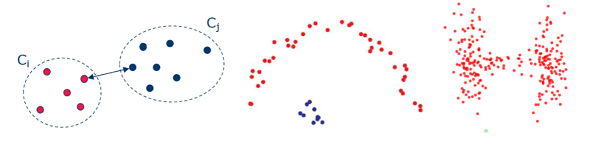

# Review #
Before we start, let's have a quick recap of the lectures.

# Clustering

Clustering a set of data means separating or distinguishing between several data groups.
While this sounds similar to classification, they have different objectives.

1. **Classification** tries to predict the labels of unseen data (new data). (*supervised learning*)
2. **Clustering** aims to group all similar data without predefined labels. (*unsupervised learning*)

In real life, classification is used in decision-making systems, such as predicting the weather, detecting defects in manufacturing, etc. In comparison, clustering is typically used for analyzing cases. For example, given the collected sales data and some basic background information about customers, we can analyze the data to identify different types of customers (by examining how they can be grouped).

Therefore, clustering and classification have very different meanings. However, in some cases, they can be used interchangeably. For example, knowing how to classify the data is similar to knowing how to cluster it by grouping data with the same predicted class together; knowing how to cluster the data is essentially the same as knowing how to classify it by assigning class labels to each cluster.

# K-Means Clustering

One of the simplest clustering algorithms is K-means clustering.
As an **unsupervised** learning algorithm, K-means clustering does not require any labels.
It only requires the desired number of clusters, **k**, to be set in advance.
<!-- K-means clustering is an **unsupervised** learning algorithm, which means it doesn't need any labels. Without labels, the model doesn't even know how many classes there are in total. In fact, that's why the algorithm is called "**K**"-mean, because the algorithm would divide all the data into "**K**" clusters, **agnostic to the exact number of groups** that may exist inside the data. -->


## Algorithm

The most standard K-means clustering algorithm is also called naive K-means and consists of the following steps:

- Choose k random data points as the *centroids* of the clusters.
- Repeat the following steps until the centroids no longer change or change very little (i.e., convergence):
  - Assign each data point to its closest centroid based on the Euclidean distance. Choose one randomly if there is more than one closest centroids.
  - Update the centroids as the means of all the data points in the respective clusters.


## Convergence

Let $X = \{\mathbf{x}_1, \dots, \mathbf{x}_n\}$ be the set of data points, and $C = \{\mathbf{c}_1, \dots, \mathbf{c}_k\}$ be the cluster centroids.
Moreover, let $A_j(X)$ be the set of data points assigned to the cluster whose centroid is $\mathbf{c}_j$.

The algorithm is **guaranteed** to converge to a **local** minimum of the sum of squared error (SSE):

$$
    \mathrm{SSE}(A, C; X) = \sum_{j=1}^{k}\sum_{\mathbf{x} \in A_j(X)}\mathrm{dist}(\mathbf{x}, \mathbf{c}_j)^2
$$

where $\mathrm{dist}(\cdot, \cdot)$ is the Euclidean distance.
Moreover, SSE **decreases monotonically** until convergence, making it a great metric to check whether the algorithm has (nearly) converged.

Below is a proof of the convergence and the monotonicity of SSE in case you are interested.

### Proof

We use superscript $t$ to denote the number of iterations completed at a certain time.
We show that for any $t > 1$, $\mathrm{SSE}(A^t, C^t; X) \leq \mathrm{SSE}(A^{t-1}, C^{t-1}; X)$ and the equality holds if and only if $C^{t-1} = C^t$.

First, since every data point is assigned to its closest centroid, we have $\mathrm{SSE}(A^t, C^{t-1}; X) \leq \mathrm{SSE}(A^{t-1}, C^{t-1}; X)$, which is obvious.

Next, let $\boldsymbol{\delta}_j = \mathbf{c}_j^{t-1} - \mathbf{c}_j^t$, we have $\mathrm{SSE}(A^t, C^t; X) \leq \mathrm{SSE}(A^t, C^{t-1}; X)$ because

\begin{split}
\mathrm{SSE}(A^t, C^{t-1}; X) - \mathrm{SSE}(A^t, C^t; X)
&= \sum_{j=1}^{k}\sum_{\mathbf{x}^t \in A_j^t(X)}\mathrm{dist}(\mathbf{x}^t, \mathbf{c}_j^t + \boldsymbol{\delta}_j)^2 - \mathrm{dist}(\mathbf{x}^t, \mathbf{c}_j^t)^2 \\
&= \sum_{j=1}^{k}\sum_{\mathbf{x}^t \in A_j^t(X)} -2 \boldsymbol{\delta}_j \cdot (\mathbf{x}^t - \mathbf{c}_j^t) + \lVert\boldsymbol{\delta}_j\rVert^2 \\
&= \sum_{j=1}^{k} n_j\lVert\boldsymbol{\delta}_j\rVert^2 + \sum_{j=1}^{k} 2 n_j \boldsymbol{\delta}_j \cdot \left( \mathbf{c}_j^t - \frac{1}{n_j}\sum_{\mathbf{x}^t \in A_j^t(X)} \mathbf{x}^t  \right)\\
&= \sum_{j=1}^{k} n_j\lVert\boldsymbol{\delta}_j\rVert^2 \geq 0
\end{split}

where $n_j$ is the number of data points in $A_j(X)$. This completes the proof.

## Stopping criterion

As we have seen, the convergence of K-means clustering means that the centroids do not change, or equivalently, that the SSE does not decrease.
In theory, to achieve the best results, we should not stop until we reach final convergence.

In real-world cases, however, we often stop **when the change in the centroids or the SSE is smaller** than a specified threshold value.
This **saves time without sacrificing too much performance**, as the final convergence may take much longer while yielding very little improvement.

Additionally, we can use the **maximum number of iterations** as a stopping criterion when it is difficult to determine what the threshold value should be.

## Limitations

There are several limitations of K-means clustering. Some of these limitations include:
- It is very sensitive to centroids initialization and outliers.
- It fits poorly on data groups with complex shapes (non-hyperellipsoids or hyperspheres).
- The choice of k can lead to drastically different results.
- It cannot handle categorical feature values effectively.

We will now take a closer look at these limitations one by one.
We will use the `KMeans` class from the scikit-learn library to demonstrate these limitations.

To begin, we will create a synthetic 2D dataset with four clusters.

Features (X.shape): (400, 2)


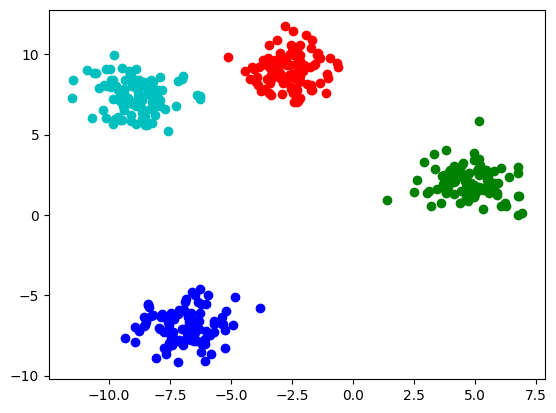

In [15]:
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.cluster import KMeans

def plot_diagram(X, y=None, k=None):
    cycol = cycle('rgbcmk')                             # Create a color cycle iterable object
    if y is not None:                                   # y is the label of each individual points
        if k is None:                                   # k is number of cluster there is
            k = y.max() + 1                             # The total number of clusters is the max label + 1, assuming
                                                        # the class labels are consecutive and start from 0
        for i, c in zip(range(k), cycol):
            plt.scatter(*X[y == i].T, c=c)              # Plot points of class with color c

def plot_points(points, marker='o'):
    plt.scatter(*points, c='w', marker=marker)          # Plot points with color white and specified shape

# Create a dataset with 4 blobs of cluster
X, y = datasets.make_blobs(400, 2, centers=4, random_state=42)
plot_diagram(X, y)
print('Features (X.shape):', X.shape)

### Limitation 1 -  Very sensitive to centroids initialization and outliers

After generating the dataset, we run the K-means algorithm on it to identify the clusters.
For the first model, we set the random seed to **5** during initialization and provide the true number of clusters (four clusters) for the model. We can see that the algorithm correctly clusters our data points into 4 distinct clusters.

KMeans using random seed 5 to initialize 4 cluster centroids.


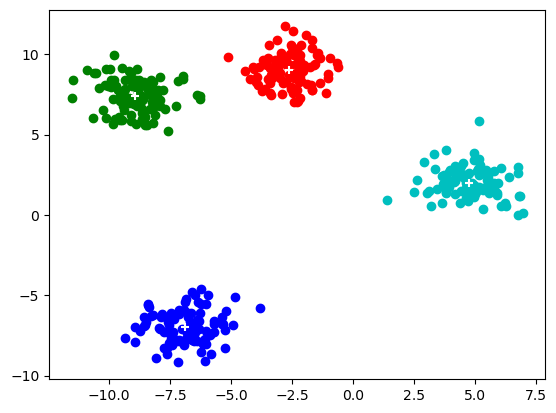

In [ ]:
kmeans_seed5 = KMeans(n_clusters=4, random_state=5, init='random', n_init=1)
kmeans_seed5 = kmeans_seed5.fit(X)
print('KMeans using random seed 5 to initialize 4 cluster centroids.')
plot_diagram(X, kmeans_seed5.labels_, 4)
plot_points(kmeans_seed5.cluster_centers_.T, marker='+')

Next, let's try running K-means with a different random seed for initialization, specifically random seed **1**. We can observe that this results in poor clustering, even though the algorithm has converged.

KMeans using random seed 1 to initialize 4 cluster centroids.


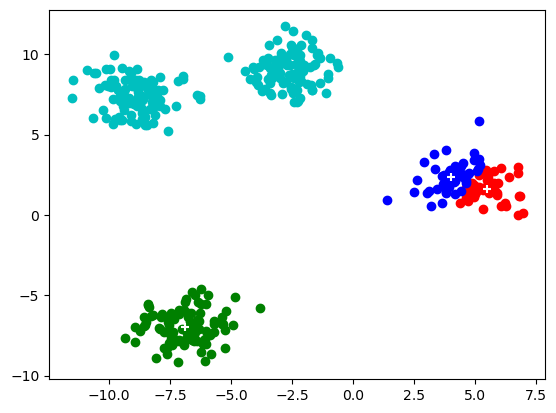

In [ ]:
kmeans_seed1 = KMeans(n_clusters=4, random_state=1, init='random', n_init=1)
kmeans_seed1 = kmeans_seed1.fit(X)
print('KMeans using random seed 1 to initialize 4 cluster centroids.')
plot_diagram(X, kmeans_seed1.labels_, 4)
plot_points(kmeans_seed1.cluster_centers_.T, marker='+')

In addition to being sensitive to random initialization, K-means is also sensitive to outliers because the mean value (used by the algorithm to calculate the centroids) can be easily influenced by extreme values. As shown below, a few outliers make the solution clearly undesirable.

KMeans using random seed 5 to initialize 4 cluster centroids.


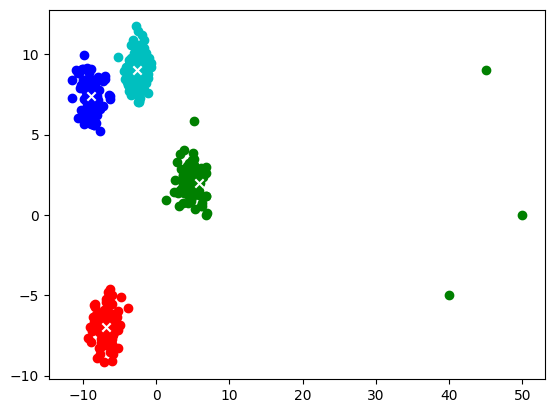

In [22]:
outliers = np.array([(50, 0), (45, 9), (40, -5)])
X_with_outliers = np.vstack([X, outliers])
kmeans_seed5_with_outliers = KMeans(n_clusters=4, random_state=5, init='random', n_init=1)
kmeans_seed5_with_outliers = kmeans_seed5_with_outliers.fit(X_with_outliers)
print('KMeans using random seed 5 to initialize 4 cluster centroids.')
plot_diagram(X_with_outliers, kmeans_seed5_with_outliers.labels_, 4)
plot_points(kmeans_seed5_with_outliers.cluster_centers_.T, marker='x')

To avoid these issues, we should first remove any outliers from the data, run the algorithm multiple times with different initializations, and then select the one with the smallest SSE.

In [ ]:
kmeans_seed1.inertia_, kmeans_seed5.inertia_  # here in sklearn, inertia_ means SSE

(2816.6639795926117, 766.5183043840315)

### Limitation 2 -  Fits poorly on data groups in sophisticated shapes

In general, K-means performs well only on data groups with convex (or near-convex) shapes because the data points are always assigned to their closest centroids. Below, a) are examples of convex shapes, and (b) are examples of non-convex shapes.

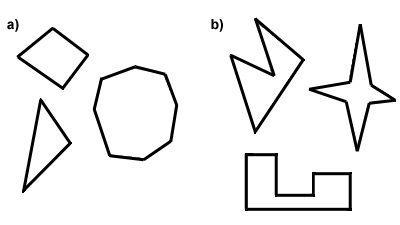

Let’s look at an example where K-means cannot generate good clusters at all.

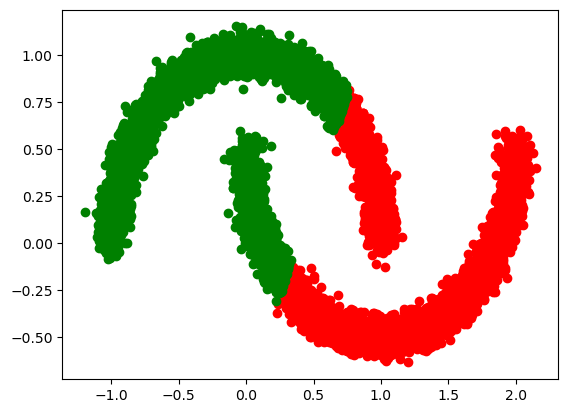

In [ ]:
X_moon, y_moon = datasets.make_moons(10000, noise=0.05)
kmeans_moons = KMeans(n_clusters=2)
kmeans_moons = kmeans_moons.fit(X_moon)
plot_diagram(X_moon, kmeans_moons.labels_, 2)
plot_points(kmeans_moons.cluster_centers_.T, marker='+')

For such datasets, we need to use more advanced clustering algorithms. Refer to [this](https://scikit-learn.org/stable/modules/clustering.html) for a comparison of various clustering algorithms.

### Limitation 3: The choice of K can lead to drastically different results

For K-means, we need to set the number of clusters in advance. However, we may not know how many clusters exist in the data distribution beforehand. Moreover, sometimes the number of clusters is precisely what we want to determine.
If K is not set properly, the algorithm wll not perform well.

Here, let’s reuse the previous well-clustered example but set the number of clusters to **6 (instead of 4)**.

KMeans using random seed 5 to initialize 6 cluster centroids.


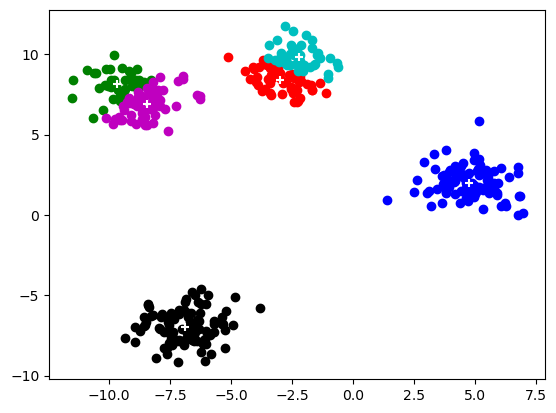

In [ ]:
kmeans_seed5_new = KMeans(n_clusters=6, random_state=5, init='random', n_init=1)
kmeans_seed5_new = kmeans_seed5_new.fit(X)
print('KMeans using random seed 5 to initialize 6 cluster centroids.')
plot_diagram(X, kmeans_seed5_new.labels_, 6)
plot_points(kmeans_seed5_new.cluster_centers_.T, marker='+')

The result is clearly undesirable, even though the SSE is smaller.

In [ ]:
kmeans_seed5.inertia_, kmeans_seed5_new.inertia_  # here in sklearn, inertia_ means SSE

(766.5183043840315, 625.6722019003073)

There are several methods to help us select a good K, such as the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) and the [Silhouette method](https://en.wikipedia.org/wiki/Silhouette_(clustering)).
The Elbow method is relatively easy to understand, although often less reliable, and it uses SSE to help determine the value of k.

### Limitation 4 -  Cannot handle categorical features

An example of numerical features is **people’s height: 180 cm, 160 cm, 175 cm, etc.** <br>
An example of categorical features is **favorite animal: cat, dog, elephant, etc.**

Problem: Categorical features do not have inherent values, and thus we cannot compute their means.

Solution: **K-modes** and **K-prototypes**.

#### K-modes
K-modes follows the same procedure as K-means, except for two key differences:
1. Instead of calculating the **Euclidean Distance** between each data point and cluster centroids, it uses the **Hamming Distance** as the measure of distance. Essentially, it measures the number of features that differ. See reference: https://en.wikipedia.org/wiki/Hamming_distance.
2. Instead of calculating the **mean** value of data points assigned to the same cluster to find the new centroids, it computes the **mode** value-the most common category of each feature among the assigned data points in a cluster.

K-modes can handle categorical features, but it loses the ability to process numerical features.

#### K-prototypes
For data with both numerical and categorical features, which is often the case in real applications, we can use K-prototypes.
K-prototypes treat the two types of features **separately**:

- For each numerical feature, it computes the **Euclidean distance** and the **mean**;
- For each categorical feature, it computes the **Hamming distance** and the **mode**.

The final distance is a combination of those distances.

Now, we have a model that can handle both categorical and numerical features. There are many other variants of K-means that address its limitations. Next, we will implement another variant of K-means ourselves.

In [ ]:
### This is the end of the review
### Designed by COMP2211 teaching team

### Appendix - Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a statistical technique commonly used for dimensionality reduction, data visualization, and feature extraction. It transforms high-dimensional data into a lower-dimensional space while preserving as much variance as possible.

Next we will show you how to use the PCA package.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [ ]:
# Standardize Data
X_std = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

X_pca

array([[-2.26470281,  0.4800266 ],
       [-2.08096115, -0.67413356],
       [-2.36422905, -0.34190802],
       [-2.29938422, -0.59739451],
       [-2.38984217,  0.64683538],
       [-2.07563095,  1.48917752],
       [-2.44402884,  0.0476442 ],
       [-2.23284716,  0.22314807],
       [-2.33464048, -1.11532768],
       [-2.18432817, -0.46901356],
       [-2.1663101 ,  1.04369065],
       [-2.32613087,  0.13307834],
       [-2.2184509 , -0.72867617],
       [-2.6331007 , -0.96150673],
       [-2.1987406 ,  1.86005711],
       [-2.26221453,  2.68628449],
       [-2.2075877 ,  1.48360936],
       [-2.19034951,  0.48883832],
       [-1.898572  ,  1.40501879],
       [-2.34336905,  1.12784938],
       [-1.914323  ,  0.40885571],
       [-2.20701284,  0.92412143],
       [-2.7743447 ,  0.45834367],
       [-1.81866953,  0.08555853],
       [-2.22716331,  0.13725446],
       [-1.95184633, -0.62561859],
       [-2.05115137,  0.24216355],
       [-2.16857717,  0.52714953],
       [-2.13956345,

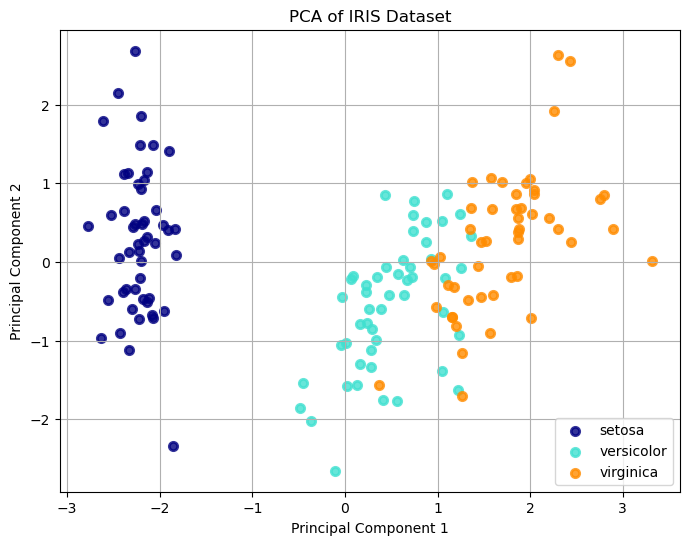

In [ ]:
 # Create DataFrame for visualization
df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df['target'] = y

plt.figure(figsize=(8, 6))
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(df.loc[df['target'] == i, 'PC1'],
                df.loc[df['target'] == i, 'PC2'],
                color=color, alpha=.8, lw=lw, label=target_name)

plt.title('PCA of IRIS Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.grid()
plt.show()